In [42]:
import numpy as np
import time
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
import matplotlib.ticker as mticker
from matplotlib.ticker import MultipleLocator,StrMethodFormatter,ScalarFormatter

In [43]:
# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [44]:
# Negative log likelihood of logistic regression (Bernoulli likelihood)
def neg_log_likelihood(X, y, beta):
    logits = np.dot(X, beta)
    return -np.sum(y * np.log(sigmoid(logits)) + (1 - y) * np.log(1 - sigmoid(logits)))

In [45]:
# Gradient of the negative log likelihood
def neg_log_likelihood_gradient(X, y, beta):
    probabilities = sigmoid(np.dot(X, beta))
    return np.dot(X.T, probabilities - y)

In [46]:
# Negative log posterior (negative log likelihood + L2 prior on parameters)
def neg_log_posterior(X, y, beta, lamb):
    return neg_log_likelihood(X, y, beta) + (lamb / 2) * np.sum(beta**2)

In [47]:
# Gradient of the negative log posterior
def neg_log_posterior_gradient(X, y, beta, lamb):
    return neg_log_likelihood_gradient(X, y, beta) + lamb * beta

In [48]:
def LMC_log_regression(X, y, k, x0, d, lamb,freq):
    gamma = 1/(k**(4/5))
    x = x0.copy()
    all_iterates = []
    num_of_clients = len(X)
    client_data = np.zeros((num_of_clients,d))
    for iteration in tqdm(range(k)):
        for idx in range(num_of_clients):
            client_data[idx] = neg_log_posterior_gradient(X[idx], y[idx], x, lamb) 
        noise = np.sqrt(2 * gamma) * np.random.normal(size=d)
        x -= gamma * client_data.mean(axis=0) + noise
        if np.mod(iteration,freq) == 0:
            all_iterates.append(x.copy())
    return all_iterates

In [49]:
def penalized_LMC_log_regression(X, y, k, x0, d, lamb, freq):
    gamma = 1/(k**(4/5))
    x = x0.copy()
    all_iterates = []
    num_of_clients = len(X)
    client_data = np.zeros((num_of_clients,d))
    for iteration in tqdm(range(k)):
        for idx in range(num_of_clients):
            client_data[idx] = neg_log_posterior_gradient(X[idx], y[idx], x, lamb) + 1/(1 + iteration*gamma)
        noise = np.sqrt(2 * gamma) * np.random.normal(size=d)
        x -= gamma * client_data.mean(axis=0) + noise
        if np.mod(iteration,freq) == 0:
            all_iterates.append(x.copy())

    return all_iterates

In [50]:
dataset = 'mushrooms'

In [51]:
X, y = load_svmlight_file(f'{dataset}.txt')
X = X.toarray()
y = (y == 1).astype(int)

In [52]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
num_of_clients=40

In [54]:
X_train_client = np.array_split(X_train,num_of_clients)
X_test_client = np.array_split(X_test,num_of_clients)
y_train_client = np.array_split(y_train,num_of_clients)
y_test_client = np.array_split(y_test,num_of_clients)

In [55]:
# Set the parameters for LMC
h = 0.0001  # step size
lamb = 1  # regularization parameter
d = X_train.shape[1]  # number of features
x0 = np.random.randn(d)  # initialize x0
k = 800  # number of iterations
freq = 10

In [56]:
m = 80 # how many iterates to average

In [57]:
iterates = penalized_LMC_log_regression(X_train_client, y_train_client, k, x0, d, lamb, freq)
orig_iterates = LMC_log_regression(X_train_client, y_train_client, k, x0, d, lamb, freq)

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

In [58]:
lensize=len(iterates)

In [59]:
accuracy_list=[]
orig_accuracy_list = []

In [60]:
for i in range(lensize):
    start_index = max(0, i - m + 1)
    end_index = i + 1
    # Calculate the rolling average of the selected entries
    rolling_average_final_estimator = np.mean(iterates[start_index:end_index], axis=0)
    original_estimator = np.mean(orig_iterates[start_index:end_index], axis=0)
    logits_test = np.dot(X_test, rolling_average_final_estimator)
    orig_logits_test = np.dot(X_test, original_estimator)
    # Apply the sigmoid function to get probabilities
    probabilities_test = sigmoid(logits_test)
    orig_probabilities_test = sigmoid(orig_logits_test)
    # Classify based on a threshold (e.g., 0.5)
    predictions_test = (probabilities_test >= 0.5).astype(int)
    orig_predictions_test = (orig_probabilities_test >= 0.5).astype(int)
    # Evaluate the accuracy on the test set
    accuracy_test = np.mean(predictions_test == y_test)
    orig_accuracy_test = np.mean(orig_predictions_test == y_test)
    # Append the accuracy value to the list
    accuracy_list.append(accuracy_test)
    orig_accuracy_list.append(orig_accuracy_test)
accuracy_array = np.array(accuracy_list)
orig_accuracy_array=np.array(orig_accuracy_list)

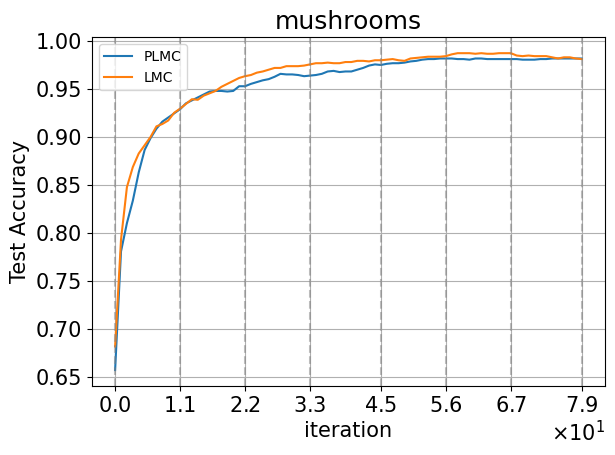

In [61]:
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 15})

scaled_x_values = np.arange(len(accuracy_array))
plt.plot(scaled_x_values, accuracy_array, label='PLMC')  
plt.plot(scaled_x_values, orig_accuracy_array,label='LMC')

plt.xlabel('iteration')
plt.ylabel('Test Accuracy')
plt.title(f'{dataset}')

# Set ticks
ticks = np.linspace(0, np.arange(80).max(), 8).astype(int)
ax.set_xticks(ticks)


formatter = ScalarFormatter(useMathText=True)  
formatter.set_scientific(True)
formatter.set_powerlimits((0,1)) 
ax.xaxis.set_major_formatter(formatter)

for x_value in ax.get_xticks():
    ax.axvline(x=x_value, linestyle='--', color='gray', alpha=0.5)

plt.legend(fontsize=10)
plt.grid(True)  # Optionally add a grid
plt.tight_layout()
plt.show()


In [62]:
dataset = 'a8a'
X, y = load_svmlight_file(f'{dataset}.txt')
X = X.toarray()
y = (y == 1).astype(int)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set the parameters for LMC
gamma = 0.0001  # step size
lamb = 1  # regularization parameter
d = X_train.shape[1]  # number of features
x0 = np.random.randn(d)  # initialize x0
k = 800  # number of iterations
freq = 10


m = 80  # how many iterates to average

num_of_clients = 40

X_train_client = np.array_split(X_train,num_of_clients)
X_test_client = np.array_split(X_test,num_of_clients)
y_train_client = np.array_split(y_train,num_of_clients)
y_test_client = np.array_split(y_test,num_of_clients)

iterates = penalized_LMC_log_regression(X_train_client, y_train_client, k, x0, d, lamb, freq)
orig_iterates = LMC_log_regression(X_train_client, y_train_client, k, x0, d, lamb,freq)

lensize = len(iterates)

accuracy_list = []
orig_accuracy_list = []

for i in range(lensize):
    start_index = max(0, i - m + 1)
    end_index = i + 1
    # Calculate the rolling average of the selected entries
    rolling_average_final_estimator = np.mean(iterates[start_index:end_index], axis=0)
    original_estimator = np.mean(orig_iterates[start_index:end_index], axis=0)
    logits_test = np.dot(X_test, rolling_average_final_estimator)
    orig_logits_test = np.dot(X_test, original_estimator)
    # Apply the sigmoid function to get probabilities
    probabilities_test = sigmoid(logits_test)
    orig_probabilities_test = sigmoid(orig_logits_test)
    # Classify based on a threshold (e.g., 0.5)
    predictions_test = (probabilities_test >= 0.5).astype(int)
    orig_predictions_test = (orig_probabilities_test >= 0.5).astype(int)
    # Evaluate the accuracy on the test set
    accuracy_test = np.mean(predictions_test == y_test)
    orig_accuracy_test = np.mean(orig_predictions_test == y_test)
    # Append the accuracy value to the list
    accuracy_list.append(accuracy_test)
    orig_accuracy_list.append(orig_accuracy_test)
accuracy_array = np.array(accuracy_list)
orig_accuracy_array=np.array(orig_accuracy_list)

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

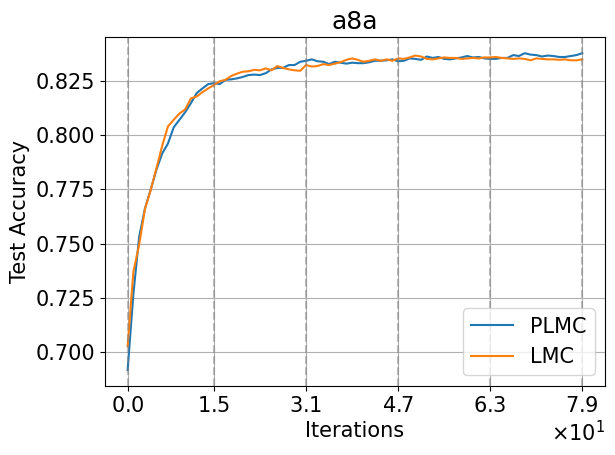

In [63]:
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 15})

scaled_x_values = np.arange(len(accuracy_array))

plt.plot(scaled_x_values, accuracy_array, label='PLMC')  # Using markers for better visibility
plt.plot(scaled_x_values, orig_accuracy_array,label='LMC')

plt.xlabel('Iterations')
plt.ylabel('Test Accuracy')
plt.title(f'{dataset}')
# Set ticks
ticks = np.linspace(0, scaled_x_values.max(), 6).astype(int)
ax.set_xticks(ticks)


formatter = ScalarFormatter(useMathText=True)  
formatter.set_scientific(True)
formatter.set_powerlimits((0,1))  
ax.xaxis.set_major_formatter(formatter)
for x_value in ax.get_xticks():
    ax.axvline(x=x_value, linestyle='--', color='gray', alpha=0.5)

plt.legend(fontsize=15)
plt.grid(True)  # Optionally add a grid
plt.tight_layout()
plt.show()

In [64]:
dataset = 'a9a'
X, y = load_svmlight_file(f'{dataset}.txt')
X = X.toarray()
y = (y == 1).astype(int)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set the parameters for LMC
gamma = 0.0001  # step size
lamb = 1  # regularization parameter
d = X_train.shape[1]  # number of features
x0 = np.random.randn(d)  # initialize x0
k = 800  # number of iterations
freq = 10


m = 80  # how many iterates to average

num_of_clients = 40

X_train_client = np.array_split(X_train,num_of_clients)
X_test_client = np.array_split(X_test,num_of_clients)
y_train_client = np.array_split(y_train,num_of_clients)
y_test_client = np.array_split(y_test,num_of_clients)

iterates = penalized_LMC_log_regression(X_train_client, y_train_client, k, x0, d, lamb, freq)
orig_iterates = LMC_log_regression(X_train_client, y_train_client, k, x0, d, lamb,freq)

lensize = len(iterates)

accuracy_list = []
orig_accuracy_list = []

for i in range(lensize):
    start_index = max(0, i - m + 1)
    end_index = i + 1
    # Calculate the rolling average of the selected entries
    rolling_average_final_estimator = np.mean(iterates[start_index:end_index], axis=0)
    original_estimator = np.mean(orig_iterates[start_index:end_index], axis=0)
    logits_test = np.dot(X_test, rolling_average_final_estimator)
    orig_logits_test = np.dot(X_test, original_estimator)
    # Apply the sigmoid function to get probabilities
    probabilities_test = sigmoid(logits_test)
    orig_probabilities_test = sigmoid(orig_logits_test)
    # Classify based on a threshold (e.g., 0.5)
    predictions_test = (probabilities_test >= 0.5).astype(int)
    orig_predictions_test = (orig_probabilities_test >= 0.5).astype(int)
    # Evaluate the accuracy on the test set
    accuracy_test = np.mean(predictions_test == y_test)
    orig_accuracy_test = np.mean(orig_predictions_test == y_test)
    # Append the accuracy value to the list
    accuracy_list.append(accuracy_test)
    orig_accuracy_list.append(orig_accuracy_test)
accuracy_array = np.array(accuracy_list)
orig_accuracy_array=np.array(orig_accuracy_list)

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

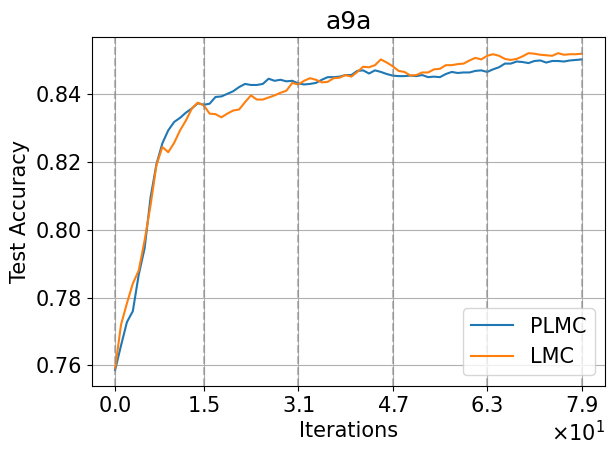

In [65]:
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 15})

scaled_x_values = np.arange(len(accuracy_array))

plt.plot(scaled_x_values, accuracy_array, label='PLMC')  # Using markers for better visibility
plt.plot(scaled_x_values, orig_accuracy_array,label='LMC')

plt.xlabel('Iterations')
plt.ylabel('Test Accuracy')
plt.title(f'{dataset}')
# Set ticks
ticks = np.linspace(0, scaled_x_values.max(), 6).astype(int)
ax.set_xticks(ticks)


formatter = ScalarFormatter(useMathText=True)  
formatter.set_scientific(True)
formatter.set_powerlimits((0,1))  
ax.xaxis.set_major_formatter(formatter)
for x_value in ax.get_xticks():
    ax.axvline(x=x_value, linestyle='--', color='gray', alpha=0.5)

plt.legend(fontsize=15)
plt.grid(True)  # Optionally add a grid
plt.tight_layout()
plt.show()